In [1]:
# Get cleaned and trusted CBS house index data from Data Hub

import requests
from requests.auth import HTTPDigestAuth
import json
import time
import pandas as pd

def getCBSIndex():
    try:
        url = 'http://ai:8011/v1/rows'
        header = {"Accept": "application/json"}
        plan = 'plan=%7B%0A"$optic":%20%7B%0A"ns":%20"op",%20%0A"fn":%20"operators",%20%0A"args":%20%5B%0A%7B%0A"ns":%20"op",%20%0A"fn":%20"from-sql",%20%0A"args":%20%5B%0A"select%20*%20from%20cbs_index%20where%20year%20>%202009order%20by%20year",%20%0Anull%0A%5D%0A%7D%0A%5D%0A%7D%0A%7D'

        response = (requests.get(url+"?"+plan, auth=HTTPDigestAuth('admin', 'admin'), headers=header).text)
        response = json.loads(response)
        time.sleep(0.5)
        return response
    except Exception as e:
        raise e
        
def parse_year(x):
    try:
        return x["value"]
    except Exception:
        x = 0
        return x
       
def parse_index(x):
    try:
        return x["value"]
    except Exception:
        x = 0
        return x
    
data = getCBSIndex()
df = pd.DataFrame(data["rows"])
df["year"] = df["cbs_index.cbs_index.year"].apply(parse_year)
df["index"] = df["cbs_index.cbs_index.price_index"].apply(parse_index)
df

,cbs_index.cbs_index.price_index,cbs_index.cbs_index.year,year,index
0,"{'type': 'xs:decimal', 'value': -2.2}","{'type': 'xs:integer', 'value': 2010}",2010,-2.2
1,"{'type': 'xs:decimal', 'value': 2.8}","{'type': 'xs:integer', 'value': 2015}",2015,2.8
2,"{'type': 'xs:decimal', 'value': 5}","{'type': 'xs:integer', 'value': 2016}",2016,5.0
3,"{'type': 'xs:decimal', 'value': 7.6}","{'type': 'xs:integer', 'value': 2017}",2017,7.6
4,"{'type': 'xs:decimal', 'value': 9}","{'type': 'xs:integer', 'value': 2018}",2018,9.0


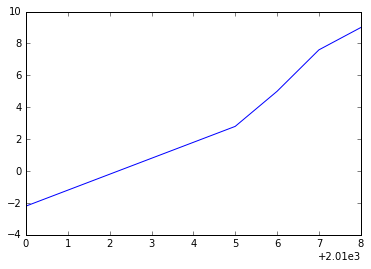

In [14]:
# Plot the CBS data in a chart

import matplotlib.pyplot as plt
plt.plot(df["year"], df["index"])
plt.show()

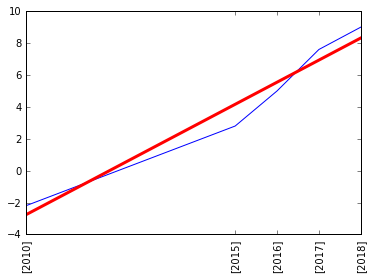

In [20]:
# Create a Linear Regression Model for the CBS data
# Plot the regression in a chart

from sklearn import datasets, linear_model
import warnings
warnings.filterwarnings(action="ignore", module="sklearn", message="^internal gelsd")

X=df['year'].values
X=X.reshape(len(X),1)
Y=df['index'].values
Y=Y.reshape(len(X),1)

model = linear_model.LinearRegression().fit(X,Y)
plt.plot(df["year"], df["index"])
plt.xticks(X, X, rotation='vertical')
plt.plot(X, model.predict(X), color='red',linewidth=3)
plt.show()

In [19]:
# Export to ONNX format

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([1, 1]))]
onx = convert_sklearn(model, initial_types=initial_type)

with open("/mount/CBS_Linear_Regression.onnx", "wb") as f:
    f.write(onx.SerializeToString())

ImportError: No module named 'skl2onnx'

In [ ]:
# Load the ONNX and print it out

import onnx
model = onnx.load('/tmp/CBS_Linear_Regression.onnx')
print(model)

In [ ]:
print (onx.SerializeToString())

In [ ]:
# Store the model in MarkLogic

import requests
from requests.auth import HTTPDigestAuth

try:
    url = 'http://localhost:8011/v1/documents'
    header = {"Accept": "application/json"}
    params = 'uri=/tmp/CBS_Linear_Regression.onnx'
    
    response = (requests.put(url+"?"+params, auth=HTTPDigestAuth('admin', 'admin'), headers=header, data=onx.SerializeToString()))
    print(response)
except Exception as e:
    raise e